# Power Consumption Data Exploratory Data Analysis

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ranksums

from scipy.signal import savgol_filter
from scikit_posthocs import posthoc_dunn

In [3]:
data = pd.read_csv("data\cleaned\data_all.csv")[["date", "state", "usage"]]

In [4]:
data["date"] = pd.to_datetime(data["date"])

In [5]:
data.head()

,date,state,usage
0,2019-01-02,Delhi,85.8
1,2019-01-02,Karnataka,206.3
2,2019-01-02,Maharashtra,428.6
3,2019-01-02,Rajasthan,234.1
4,2019-01-02,Tamil Nadu,268.3


To reiterate, we have data representing the total daily power consumption measured in Mega Units from 02 Jan 2019 until 01 Jan 2020 for 6 major Indian states. In this notebook I will perform exploratory data analysis and see what claims we can make about the data.

Firstly, I plot the power consumption for each state in a line plot.

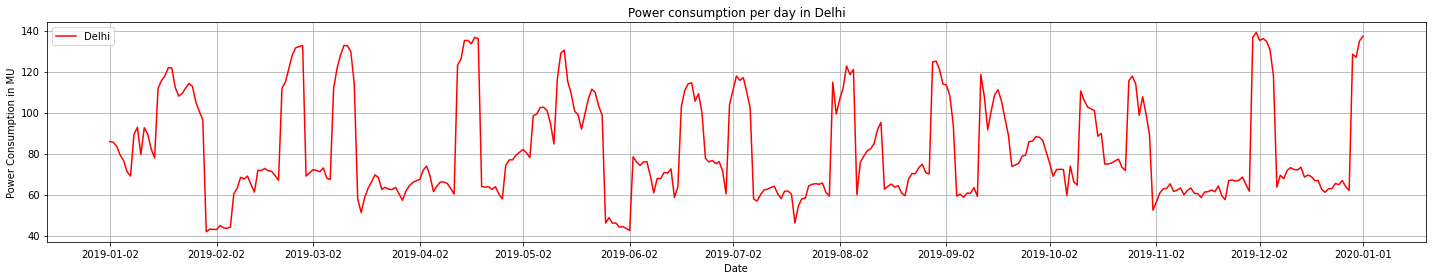

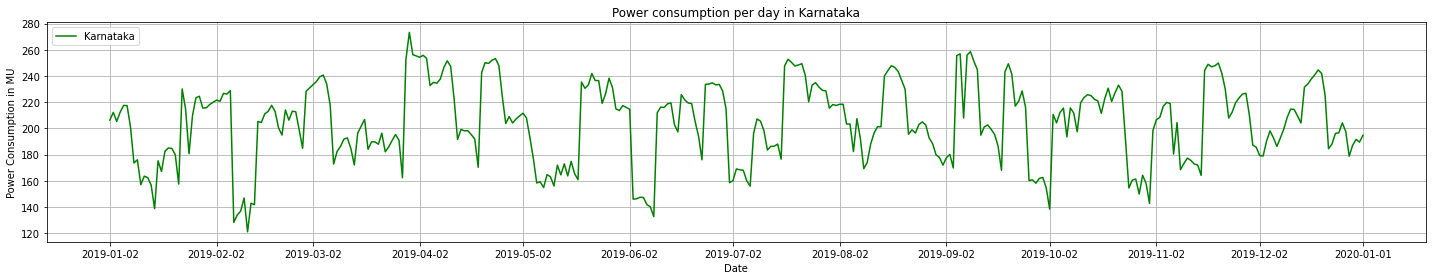

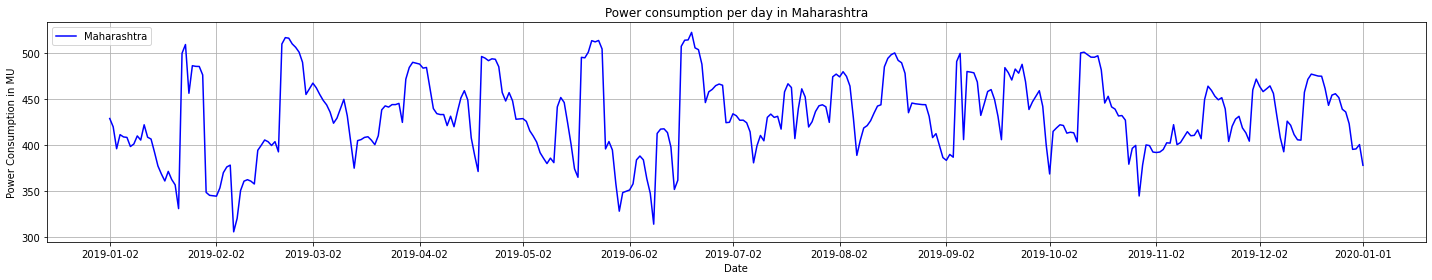

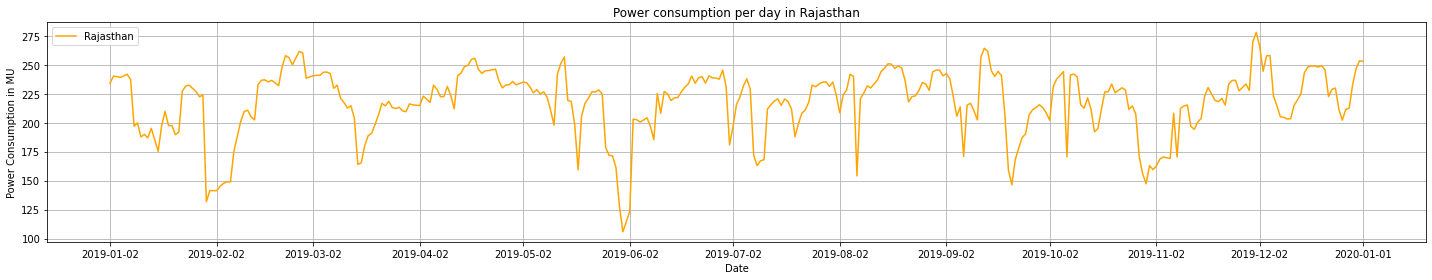

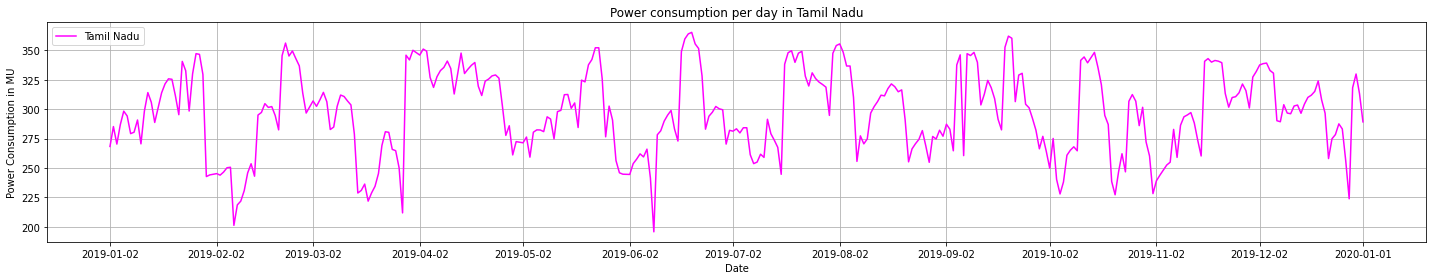

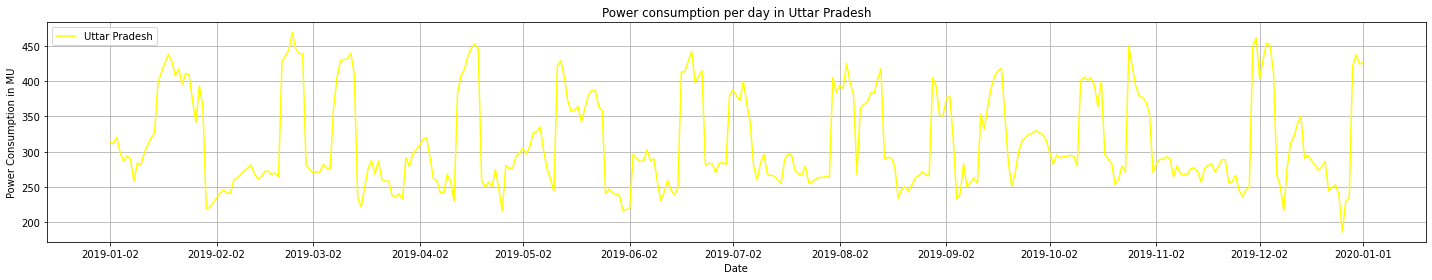

In [6]:
colors = ["red", "green", "blue", "orange", "magenta", "yellow"]
i = 0
for name, group in data.groupby("state"):
    fig, ax = plt.subplots(1, figsize=(20,4))
    df = group.set_index("date")
    plt.plot(df["usage"], label = name, color = colors[i])
    i += 1
    xticks = group[(group["date"].dt.day == 2) | (group["date"].dt.year == 2020)]["date"]
    ax.set_xticks(xticks)
    plt.xlabel("Date")
    plt.ylabel("Power Consumption in MU")
    plt.title("Power consumption per day in " + name)
    plt.tight_layout()
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

It appears that the data contains a significant amount of noise. In that case, it is customary to smooth the data in order to eliminate the noise yet retain the important information such as peaks, valleys, and tendencies. To smooth the data, I used a __[Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)__ filter. It basically takes a subset of the data and approximates it with a low-degree polynomial. That is repeated until all datapoints are filtered.

In [7]:
def smooth_usage(grouped_df):
    groups = [gr for name, gr in grouped_df]
    for df in groups:
        df.reset_index(drop = True, inplace = True)
        df["smooth_usage"] = savgol_filter(df["usage"], 15, 3)
    return pd.concat(groups).sort_values(by = ["date", "state"]).reset_index(drop = True)

In [8]:
data = smooth_usage(data.groupby("state"))

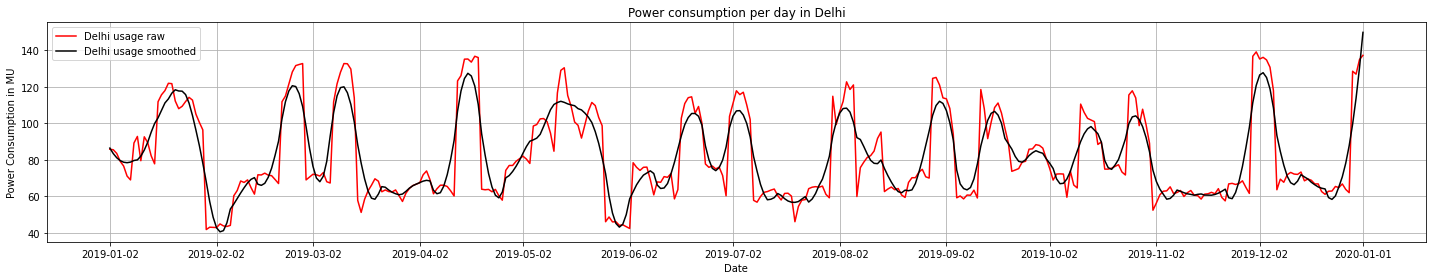

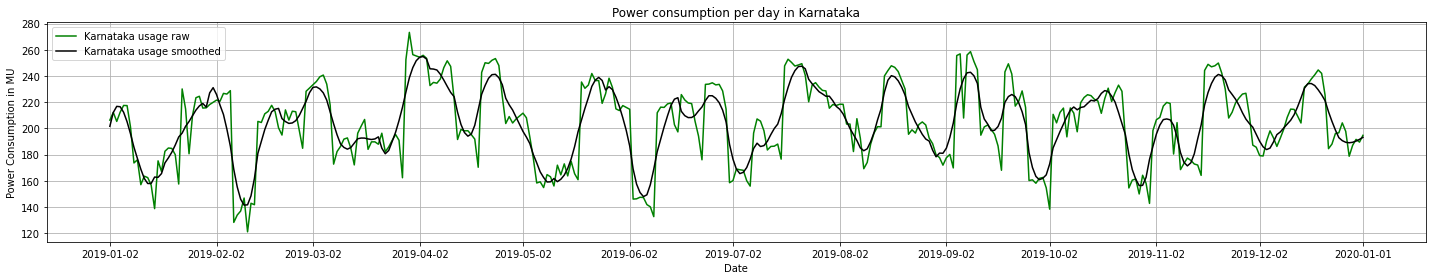

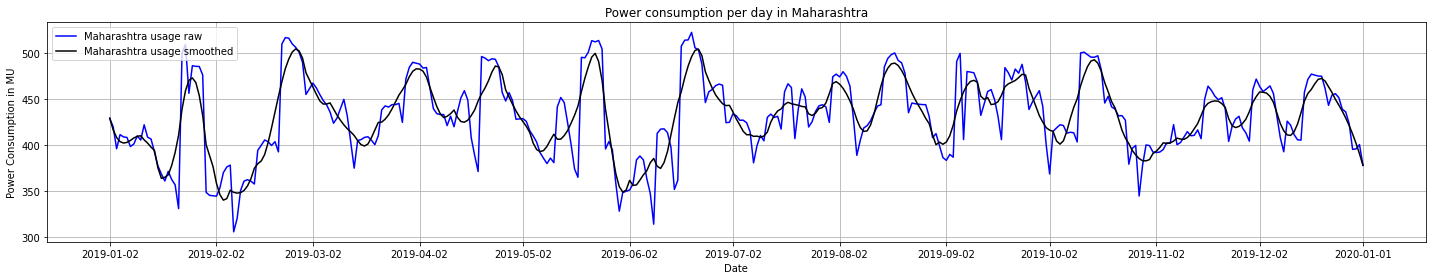

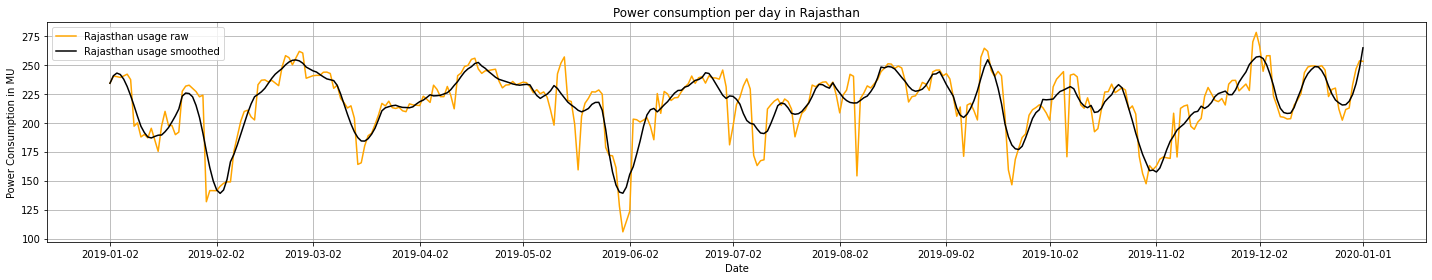

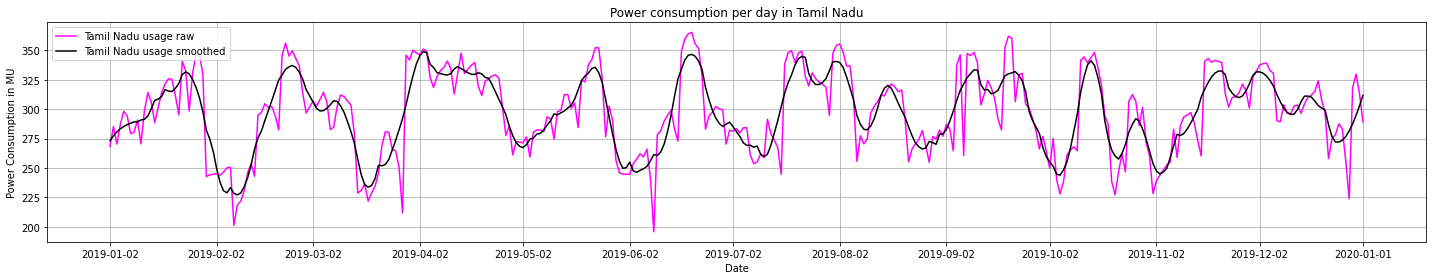

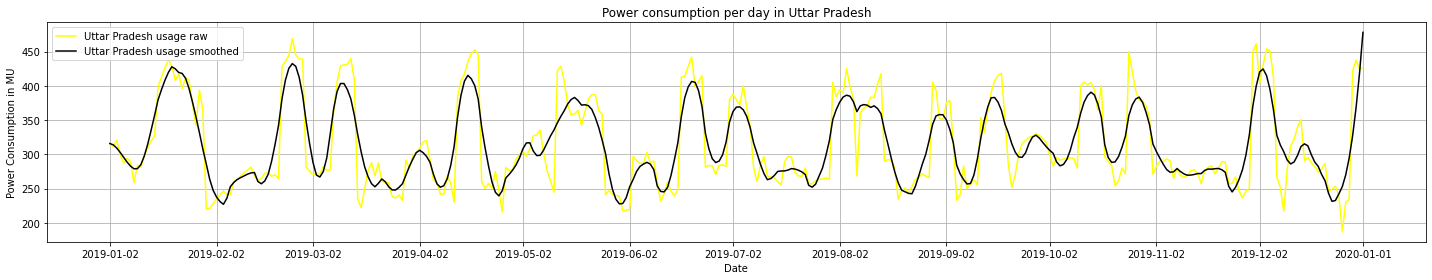

In [9]:
colors = ["red", "green", "blue", "orange", "magenta", "yellow"]
i = 0
for name, group in data.groupby("state"):
    fig, ax = plt.subplots(1, figsize=(20,4))
    df = group.set_index("date")
    plt.plot(df["usage"], label = name + " usage raw", color = colors[i])
    plt.plot(df["smooth_usage"], label = name + " usage smoothed", color = "black")
    i += 1
    xticks = group[(group["date"].dt.day == 2) | (group["date"].dt.year == 2020)]["date"]
    ax.set_xticks(xticks)
    plt.xlabel("Date")
    plt.ylabel("Power Consumption in MU")
    plt.title("Power consumption per day in " + name)
    plt.tight_layout()
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

As it can be seen from the plot, the smoothed data manages to roughly resemble the original data.

We can start our exploratory data anaylsis by testing the relationships between the power consumption and the date. I will test whether there is a difference in power consumption between weekends and weekdays, and between any 2 days of the week for all states.

In [10]:
data["weekday"] = data["date"].dt.weekday

In [11]:
data["weekend"] = 0
data.loc[(data["weekday"] == 5) | (data["weekday"] == 6), "weekend"] = 1

First of all, we check whether the power consumption is normally distributed for weekends, weekdays, and for every weekday. I test normality by using a __[Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)__ test. It tests the null hypothesis that the data is sampled from a normal distribution. If the p-value from the test is lower than 0.05, we reject the null hypothesis and confirm that the data has been sampled from a distribution that is not normal.

In [12]:
def test_normality(df, gr_col, val_col):
    for name, group in df.groupby(gr_col):
        p = shapiro(group[val_col]).pvalue
        is_normal = ""
        if p < 0.05:
            is_normal = " NOT"
        print(str(name) + ": " + val_col + " is" + is_normal + " normally distributed")

In [13]:
test_normality(data, "state", "smooth_usage")

Delhi: smooth_usage is NOT normally distributed
Karnataka: smooth_usage is NOT normally distributed
Maharashtra: smooth_usage is NOT normally distributed
Rajasthan: smooth_usage is NOT normally distributed
Tamil Nadu: smooth_usage is NOT normally distributed
Uttar Pradesh: smooth_usage is NOT normally distributed


In [14]:
for name, group in data.groupby("state"):
    print(name + " usage per weekday")
    test_normality(group, "weekday", "smooth_usage")
    print()

Delhi usage per weekday
0: smooth_usage is NOT normally distributed
1: smooth_usage is NOT normally distributed
2: smooth_usage is NOT normally distributed
3: smooth_usage is normally distributed
4: smooth_usage is NOT normally distributed
5: smooth_usage is NOT normally distributed
6: smooth_usage is NOT normally distributed

Karnataka usage per weekday
0: smooth_usage is normally distributed
1: smooth_usage is normally distributed
2: smooth_usage is normally distributed
3: smooth_usage is normally distributed
4: smooth_usage is normally distributed
5: smooth_usage is normally distributed
6: smooth_usage is normally distributed

Maharashtra usage per weekday
0: smooth_usage is normally distributed
1: smooth_usage is normally distributed
2: smooth_usage is normally distributed
3: smooth_usage is normally distributed
4: smooth_usage is normally distributed
5: smooth_usage is normally distributed
6: smooth_usage is normally distributed

Rajasthan usage per weekday
0: smooth_usage is NOT 

In [15]:
for name, group in data.groupby("state"):
    print(name + " weekend and weekdays")
    test_normality(group, "weekend", "smooth_usage")
    print()

Delhi weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is NOT normally distributed

Karnataka weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is normally distributed

Maharashtra weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is normally distributed

Rajasthan weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is NOT normally distributed

Tamil Nadu weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is NOT normally distributed

Uttar Pradesh weekend and weekdays
0: smooth_usage is NOT normally distributed
1: smooth_usage is NOT normally distributed



It appears that the majority of the data for all groups is not normally distributed. That can be expected since the sample size is not very large. We can try and fix that by taking the logarithm, square root, or cube root of the data __[[1]](https://www.statology.org/transform-data-in-python/)__.

In [16]:
data["log_usage"] = np.log(data["smooth_usage"])
data["sqrt_usage"] = np.sqrt(data["smooth_usage"])
data["cbrt_usage"] = np.cbrt(data["smooth_usage"])

In [17]:
def check_if_transformations_worked(grouped_by_state_df, new_col):
    for _, group1 in grouped_by_state_df:
        if shapiro(group1[new_col]).pvalue < 0.05:
            return False
        for _, group2 in group1.groupby("weekday"):
            if shapiro(group2[new_col]).pvalue < 0.05:
                return False
        for _, group3 in group1.groupby("weekend"):
            if shapiro(group3[new_col]).pvalue < 0.05:
                return False
    return True

In [18]:
check_if_transformations_worked(data.groupby("state"), "log_usage")

False

In [19]:
check_if_transformations_worked(data.groupby("state"), "sqrt_usage")

False

In [20]:
check_if_transformations_worked(data.groupby("state"), "cbrt_usage")

False

It appears that the transformations still left instances of not normal data. For simplicity, I move on with the original data and commit to using non-parametric tests. Only non-parametric statistical tests are appropriate here since they do not make assumptions on the normality of the data, even though they lack statistical power when compared to parametric tests.

In [21]:
data = data.drop(["log_usage", "sqrt_usage", "cbrt_usage"], axis = 1) 

We begin by testing the difference in power consumption between weekends and weekdays. We can use a __[Wilcoxon signed-rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test)__ or a __[Wilcoxon rank-sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)__, which are the non-parametric alternatives of a two-samples __[t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)__. They both test the difference in medians between 2 independent populations against the null hypothesis that the 2 medians are the same. A signed-rank test assumes that both populations are symmetric, whereas a rank-sum test assumes that both populations have similar shapes. Therefore, to check which test is more appropriate, we look at the distributions


In [22]:
def plot_weekend_weekdays(grouped_df, val_col):
    for name, group in grouped_df:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

        ax1.hist(group[group["weekend"] == 0][val_col])
        ax1.set(xlabel = val_col, ylabel = "count")
        ax1.set_title("Distribution of "+ val_col + " on weekdays in " + name)

        ax2.hist(group[group["weekend"] == 1][val_col], color = "orange")
        ax2.set(xlabel = val_col, ylabel = "count")
        ax2.set_title("Distribution of "+ val_col + " on weekends in " + name)

        plt.tight_layout()
        plt.show()

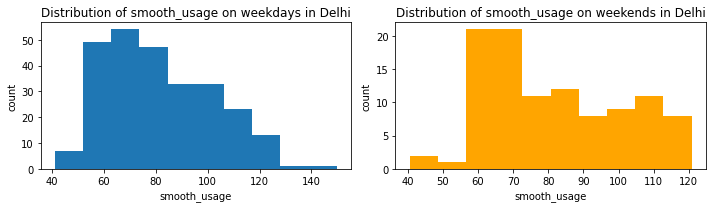

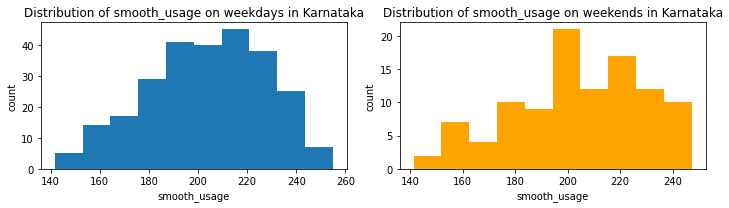

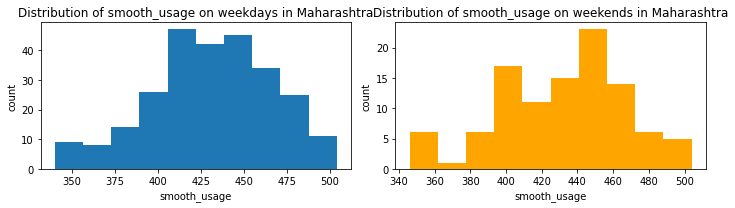

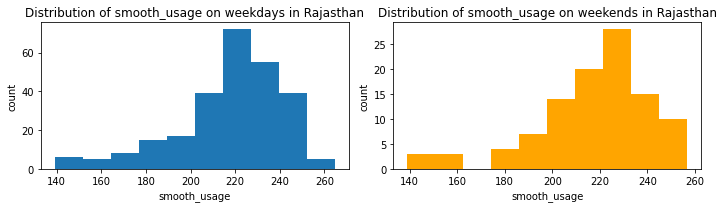

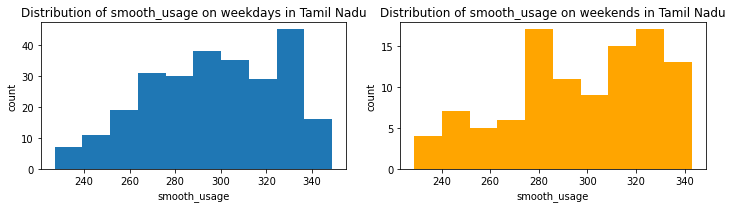

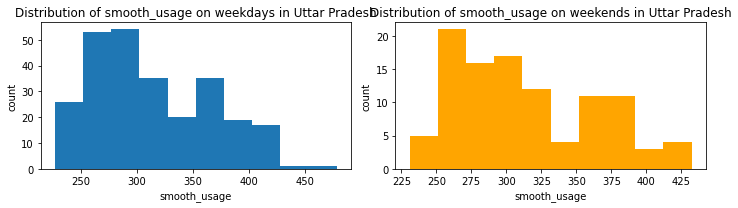

In [23]:
plot_weekend_weekdays(data.groupby("state"), "smooth_usage")

All pairs of distributions have similar shapes. Therefore, we decide to use a rank-sum test.

In [24]:
def test_weekday_weekend(grouped_df, val_col):
    for name, group in grouped_df:
        x = group[group["weekend"] == 0][val_col]
        y = group[group["weekend"] == 1][val_col]
        print(name)
        conclusion = "no"
        if ranksums(x,y).pvalue < 0.05:
            conclusion = "a"
        print("There is " + conclusion + " significant difference in " + val_col + "  usage between weekends and weekdays.")
        print()

In [25]:
test_weekday_weekend(data.groupby("state"), "smooth_usage")

Delhi
There is no significant difference in smooth_usage  usage between weekends and weekdays.

Karnataka
There is no significant difference in smooth_usage  usage between weekends and weekdays.

Maharashtra
There is no significant difference in smooth_usage  usage between weekends and weekdays.

Rajasthan
There is no significant difference in smooth_usage  usage between weekends and weekdays.

Tamil Nadu
There is no significant difference in smooth_usage  usage between weekends and weekdays.

Uttar Pradesh
There is no significant difference in smooth_usage  usage between weekends and weekdays.



The results from the tests appear insignificant for all states. Therefore, we fail to reject the null hypothesis and conclude that power consumption is not different for weekends and weekdays.

In [26]:
data = data.drop("weekend", axis = 1)

We can move on by testing whether there is a difference in power consumption between weekdays. To do that, we need to test the difference between 7 populations for every state. For that we are using a __[Kruskal-Wallis](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance)__ test which is the non-parametric alternative of the one-way __[ANOVA](https://en.wikipedia.org/wiki/One-way_analysis_of_variance)__. The test tests the medians of the populations against the null hypothesis that all medians are the same. The alternative hypothesis states that at least one of the medians is different from the others.

In [27]:
def test_usage_between_weekdays(grouped_df, val_col):
    for state, group in grouped_df:
        result = kruskal(group[group["weekday"] == 0][val_col],
                        group[group["weekday"] == 1][val_col],
                        group[group["weekday"] == 2][val_col],
                        group[group["weekday"] == 3][val_col],
                        group[group["weekday"] == 4][val_col],
                        group[group["weekday"] == 5][val_col],
                        group[group["weekday"] == 6][val_col])
        conclusion = " NO"
        if result.pvalue < 0.05:
            conclusion = ""
        print(state)
        print("There is" + conclusion + " significant difference in " + val_col + " between weekdays")

In [28]:
test_usage_between_weekdays(data.groupby("state"), "smooth_usage")

Delhi
There is NO significant difference in smooth_usage between weekdays
Karnataka
There is NO significant difference in smooth_usage between weekdays
Maharashtra
There is NO significant difference in smooth_usage between weekdays
Rajasthan
There is NO significant difference in smooth_usage between weekdays
Tamil Nadu
There is NO significant difference in smooth_usage between weekdays
Uttar Pradesh
There is NO significant difference in smooth_usage between weekdays


Again, the results of the test are insignificant for every state, therefore we fail to reject the null hypothesis and conclude that power consumption is not different for any 2 weekdays.

In [29]:
data = data.drop("weekday", axis = 1)

We finalise the exploratory data analysis by testing whether power consumption is different for each month. Again, a Kruskal-Wallis test is used that compares the medians of power consumption for every month.

In [30]:
def test_usage_between_months(grouped_df, val_col):
    for state, group in grouped_df:
        result = kruskal(group[group["date"].dt.month == 1][val_col],
                        group[group["date"].dt.month == 2][val_col],
                        group[group["date"].dt.month == 3][val_col],
                        group[group["date"].dt.month == 4][val_col],
                        group[group["date"].dt.month == 5][val_col],
                        group[group["date"].dt.month == 6][val_col],
                        group[group["date"].dt.month == 7][val_col],
                        group[group["date"].dt.month == 8][val_col],
                        group[group["date"].dt.month == 9][val_col],
                        group[group["date"].dt.month == 10][val_col],
                        group[group["date"].dt.month == 11][val_col],
                        group[group["date"].dt.month == 12][val_col])
        conclusion = "NO"
        if result.pvalue < 0.05:
            conclusion = ""
        print(state)
        print("There is" + conclusion + " significant difference in " + val_col + " between months")

In [31]:
test_usage_between_months(data.groupby("state"), "smooth_usage")

Delhi
There is significant difference in smooth_usage between months
Karnataka
There is significant difference in smooth_usage between months
Maharashtra
There is significant difference in smooth_usage between months
Rajasthan
There is significant difference in smooth_usage between months
Tamil Nadu
There is significant difference in smooth_usage between months
Uttar Pradesh
There is significant difference in smooth_usage between months


The results from the Kruskal-Wallis tests are significant for every state. Therefore, we reject the null hypothesis and conclude that the median power consumption for at least one month is different from the others.

To find exactly which 2 medians are different and how many pairs there are, we perform a __[Dunn's](https://www.statology.org/dunns-test/)__ test, which is the non-parametric alternative of a __[Tukey HSD](https://en.wikipedia.org/wiki/Tukey%27s_range_test)__ test. Dunn's test is a post hoc multiple comparisons test that tests every 2 pairs of medians and adjusts the p-values to compensate for the number of performed comparisons and thus minimize false positives. The results are displayed as tables with groups as rows and columns, where the values are are the p-values that denote the significant difference in medians for the column group and row group. We can then count the significantly different pairs of months for every state to get a perception on how important the month is for the power consumption

In [32]:
data["month"] = data["date"].dt.month

In [33]:
comparisons = [(name, posthoc_dunn(df, val_col = "smooth_usage", group_col = "month").round(3)) for name, df in data.groupby("state")]

In [34]:
print(comparisons[0][0])
comparisons[0][1]

Delhi


,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000,0.000,0.001,0.007,0.518,0.004,0.000,0.071,0.216,0.174,0.000,0.020
2,0.000,1.000,0.765,0.363,0.003,0.458,0.271,0.070,0.019,0.025,0.016,0.195
3,0.001,0.765,1.000,0.529,0.007,0.648,0.151,0.121,0.036,0.046,0.006,0.307
4,0.007,0.363,0.529,1.000,0.040,0.864,0.040,0.364,0.147,0.177,0.001,0.701
5,0.518,0.003,0.007,0.040,1.000,0.026,0.000,0.246,0.552,0.476,0.000,0.091
6,0.004,0.458,0.648,0.864,0.026,1.000,0.060,0.280,0.105,0.127,0.001,0.577
7,0.000,0.271,0.151,0.040,0.000,0.060,1.000,0.003,0.000,0.001,0.177,0.014
8,0.071,0.070,0.121,0.364,0.246,0.280,0.003,1.000,0.579,0.655,0.000,0.597
9,0.216,0.019,0.036,0.147,0.552,0.105,0.000,0.579,1.000,0.911,0.000,0.281
10,0.174,0.025,0.046,0.177,0.476,0.127,0.001,0.655,0.911,1.000,0.000,0.330


In [35]:
def get_significant_pairs(post_hoc_results):
    for i in range(len(post_hoc_results)):
        count = 0
        for col in post_hoc_results[i][1].columns:
            count += sum(post_hoc_results[i][1][col] < 0.05)
        print(post_hoc_results[i][0] + ": " + str(count/2) + " out of 61")

In [36]:
get_significant_pairs(comparisons)

Delhi: 30.0 out of 61
Karnataka: 14.0 out of 61
Maharashtra: 31.0 out of 61
Rajasthan: 26.0 out of 61
Tamil Nadu: 24.0 out of 61
Uttar Pradesh: 26.0 out of 61


It appears that, with some exceptions, roughly half of the month pairs have significantly different median power consumption for most states. The differences can also be seen in the following boxplot.

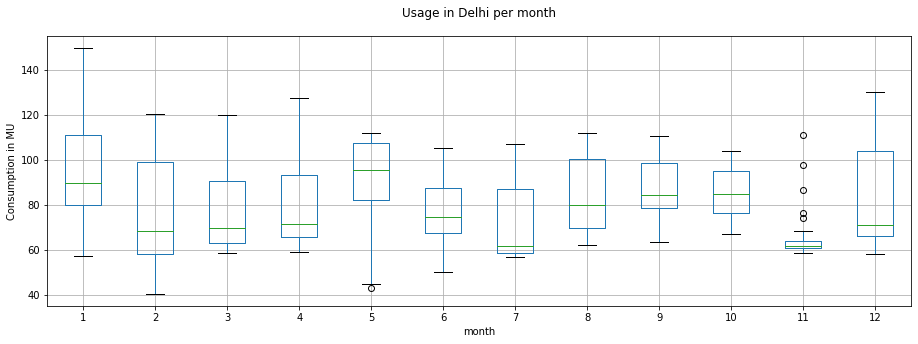

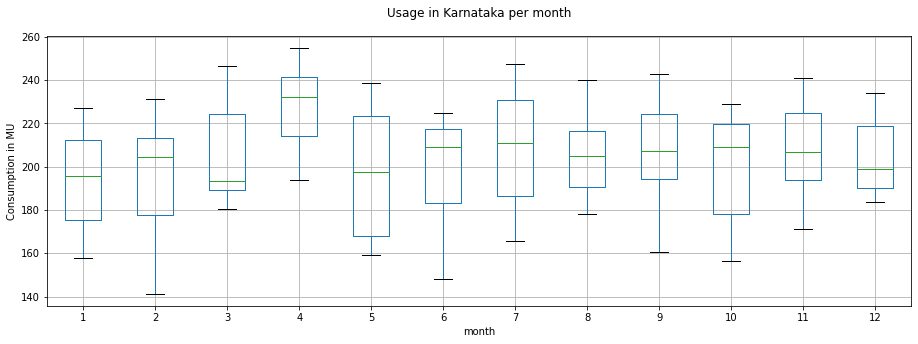

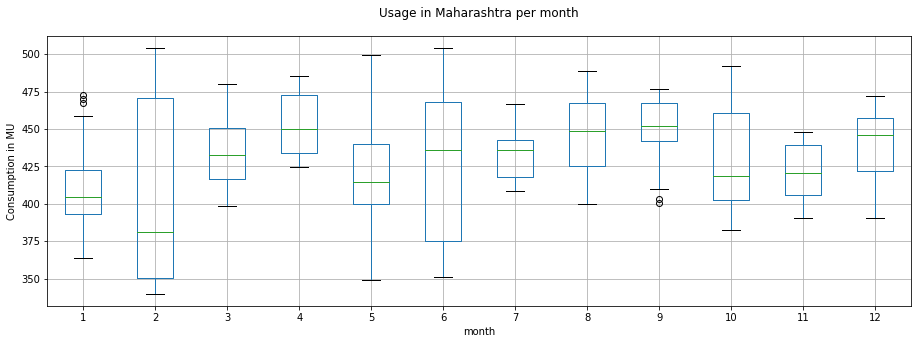

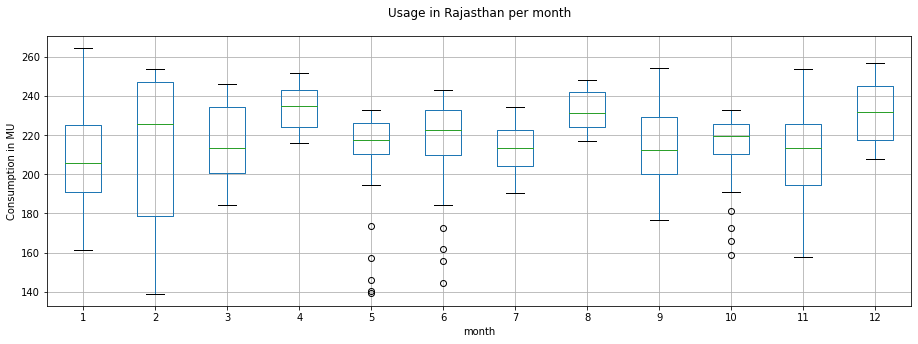

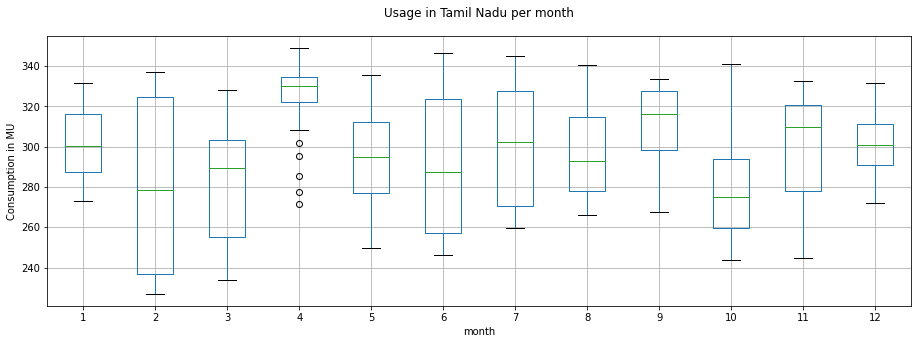

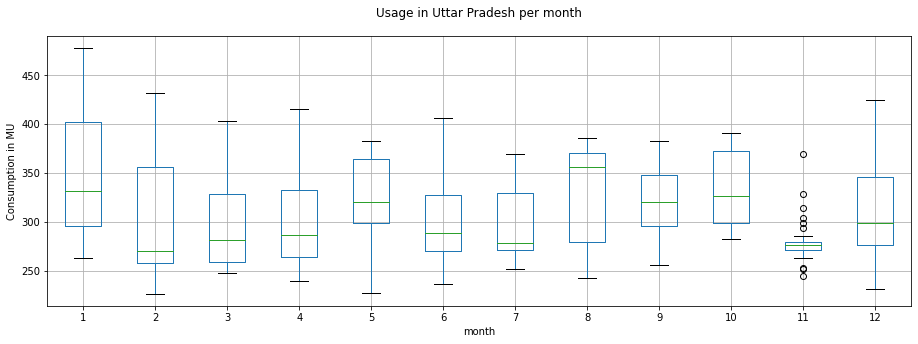

In [37]:
for name, group in data.groupby("state"):
    bp = group.boxplot(column = "smooth_usage", by = "month", figsize = (15,5))
    bp.get_figure().suptitle("Usage in " + name + " per month")
    bp.get_figure().gca().set_title("")
    bp.get_figure().gca().set_ylabel("Consumption in MU")
bp
plt.show()

It appears that the medians are oscillating similarly to a sine wave. That can also be seen in a clean line plot of the medians:

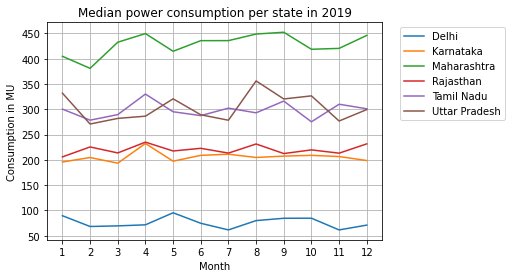

In [38]:
for name, group in data.groupby("state"):
    plt.plot(group.groupby("month")["smooth_usage"].median(), label = name)
plt.title("Median power consumption per state in 2019")
plt.xlabel("Month")
plt.ylabel("Consumption in MU")
plt.xticks(range(1,13))
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.grid()
plt.show()

With some delays, the median power consumptions per month have similar behavior in all states. That concludes the EDA for the power data. To sum up, we found that the power consumption is different for most months and its value resembles a sine-wave-looking pattern when plotted against time throughout the whole year. We can further see if we can explain this pattern by using the weather data.